In [2]:
import pandas as pd
import numpy as np
import re
import sys, getopt, os
import csv
import pickle
import copy

pd.set_option('display.max_rows', 500)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set_style("darkgrid")

%run SodaKick_download_functions.ipynb

In [3]:
#note xgboost can handle missing values internally
#list of parameters:
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://shengyg.github.io/repository/machine%20learning/2017/02/25/Complete-Guide-to-Parameter-Tuning-xgboost.html

#custom obj functions
#https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html
#https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

In [4]:
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.multioutput import MultiOutputRegressor

import xgboost as xgb
from xgboost import XGBRegressor

"""from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.integration.xgboost import TuneReportCheckpointCallback
from functools import partial 
from ray.tune.suggest.hyperopt import HyperOptSearch"""

from sklearn.model_selection import cross_val_score
#https://docs.ray.io/en/master/tune/tutorials/tune-xgboost.html

from hyperopt import hp, tpe, fmin, Trials
from hyperopt import STATUS_OK, STATUS_FAIL
from hyperopt.pyll import scope

In [5]:
#https://towardsdatascience.com/quirky-keras-custom-and-asymmetric-loss-functions-for-keras-in-r-a8b5271171fe
def WSE(output, target, a=1.5, b=.5):
    loss = torch.mean(a*torch.minimum(torch.zeros(output.shape[1]),output - target)**2+\
                      b*torch.maximum(torch.zeros(output.shape[1]),output - target)**2)      
    return loss

def WSEl1(output, target, a=1.5, b=.5):
    loss = torch.mean(a*torch.abs(torch.minimum(torch.zeros(output.shape[1]),output - target))+\
                      b*torch.abs(torch.maximum(torch.zeros(output.shape[1]),output - target)))      
    return loss

def WSE2(output, target, a=1.5, b=.5):
    loss = np.mean(a*np.minimum(np.zeros(output.shape[0]),output - target)**2+\
                      b*np.maximum(np.zeros(output.shape[0]),output - target)**2)      
    return loss

def WSEl12(output, target, a=1.5, b=.5):
    loss = np.mean(a*np.abs(np.minimum(np.zeros(output.shape[0]),output - target))+\
                      b*np.abs(np.maximum(np.zeros(output.shape[0]),output - target)))      
    return loss

In [6]:
def normalize_mins(vec):
    for i in range(vec.shape[0]):
        vec[i][::8]=vec[i][::8]/90

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def NormalizeMatrix(data):   
    for i in range(data.shape[1]):
        data[:,i] = NormalizeData(data[:,i])

def norm_max(out):
    
    maxes=[]
    for i in range(int(out.shape[1]/8.0)):
        maxes.append(out[:,8*int(i):8*(int(i)+1)].max(axis=0))

        #maxes.append(out.max(axis=1)[8*int(i):8*(int(i)+1):8])
    denominator=np.tile(np.max(maxes,axis=0),int(out.shape[1]/8))
    return out/denominator, denominator 

with open(r'/Users/federico comitani/GitHub/sodakick/data/wainp_220303.pkl', 'rb') as pk:
    inp=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/out_220303.pkl', 'rb') as pk:
    out=np.array(pickle.load(pk),dtype=float)
    
### skipping norm for now since it's already tsvd 
#NormalizeMatrix(inp)
#np.nan_to_num(inp, copy=False)

from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
inp = scaler.fit_transform(inp)

#normalize_mins(out)
out, denominator= norm_max(out)

In [7]:
from typing import Tuple

def WSE(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    
    target = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    
    a=1.5
    b=.5
    
    elements = a*np.minimum(np.zeros(len(predt)),predt - target)**2+\
                      b*np.maximum(np.zeros(len(predt)),predt - target)**2
    
    return 'WSE', float(np.sqrt(np.sum(elements) / len(target)))

In [8]:
"""from sklearn.metrics import mean_squared_error

def train_xgb(config, col=0):
    
    train_x, test_x, train_y, test_y = train_test_split(
         inp, out[:,col], test_size=0.2)
    train_set = xgb.DMatrix(train_x, label=train_y)
    test_set = xgb.DMatrix(test_x, label=test_y)  
    
    results = {}
    xgb.train(
         config,
         train_set,
         evals=[(test_set, "eval")],
         evals_result=results,
         verbose_eval=False,
         callbacks=[TuneReportCheckpointCallback(filename="model.xgb")])
    
    #error = results["eval"]["error"][-1]
    rmse = results["eval"]["rmse"][-1]
    tune.report(rmse=rmse, done=True)
    
def get_best_model_checkpoint(analysis):
    best_bst = xgb.Booster()
    best_bst.load_model(os.path.join(analysis.best_checkpoint, "model.xgb"))
    #error = analysis.best_result["eval-error"]
    rmse = analysis.best_result["eval-rmse"]
    print(f"Best model parameters: {analysis.best_config}")
    #print(f"Best model total error: {error:.4f}")
    print(f"Best model rmse: {rmse:.4f}")
    
    return best_bst"""

'from sklearn.metrics import mean_squared_error\n\ndef train_xgb(config, col=0):\n    \n    train_x, test_x, train_y, test_y = train_test_split(\n         inp, out[:,col], test_size=0.2)\n    train_set = xgb.DMatrix(train_x, label=train_y)\n    test_set = xgb.DMatrix(test_x, label=test_y)  \n    \n    results = {}\n    xgb.train(\n         config,\n         train_set,\n         evals=[(test_set, "eval")],\n         evals_result=results,\n         verbose_eval=False,\n         callbacks=[TuneReportCheckpointCallback(filename="model.xgb")])\n    \n    #error = results["eval"]["error"][-1]\n    rmse = results["eval"]["rmse"][-1]\n    tune.report(rmse=rmse, done=True)\n    \ndef get_best_model_checkpoint(analysis):\n    best_bst = xgb.Booster()\n    best_bst.load_model(os.path.join(analysis.best_checkpoint, "model.xgb"))\n    #error = analysis.best_result["eval-error"]\n    rmse = analysis.best_result["eval-rmse"]\n    print(f"Best model parameters: {analysis.best_config}")\n    #print(f"B

In [9]:
search_space = {
 "n_estimators": 100,
 "max_depth": 2+hp.randint('max_depth', 13),
 "min_child_weight": hp.choice("min_child_weight",[1, 2, 3, 4, 5]),
 "subsample": hp.choice("subsample",np.linspace(.5,.9,5)),
 "eta": hp.choice("eta",[1e-2, 5e-2, 1e-1, 5e-1, 3e-1]),
 "colsample_bytree": hp.choice("colsample_bytree",np.linspace(0.1,.9,9)),
 "alpha": hp.randint("alpha", 5),
 "lambda": hp.randint("lambda", 10),
 "gamma" : hp.choice("gamma",np.linspace(0,.9,10)),
 "objective": "reg:pseudohubererror",
 "eval_metric": "rmse", 
 "learning_rate": 1e-1, 
 }

x_train, x_test, y_train, y_test = train_test_split(
         inp[:1000], out[:1000], test_size=0.2, random_state=32)

"""
x_train, x_test, y_train, y_test = train_test_split(
     inp, out, test_size=0.5, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(
     x_train, y_train, test_size=0.3, shuffle=True)

def train_xgb(config, col=0):
    
    model = XGBRegressor(**config)
    eval_set = [(x_train, y_train[:,col]),(x_test, y_test[:,col])]
    model.fit(x_train, y_train[:,col], eval_metric=config['eval_metric'], eval_set=eval_set, early_stopping_rounds = 5, verbose=False)    
    
    evals_result = model.evals_result()
    
    #preds = model.predict(x_test,ntree_limit=model.get_booster().best_ntree_limit)]
    
    tune.report(rmse = evals_result['validation_1']['rmse'][-1], done=True)    

def tune_xgb(search_space, col):
    
    search_alg = HyperOptSearch(space=search_space, metric="rmse", mode="min")

    # This will enable aggressive early stopping of bad trials.
    #scheduler = ASHAScheduler(
    #    max_t=20,  # 10 training iterations
    #    grace_period=5,
    #    reduction_factor=2)

    analysis = tune.run(
        partial(train_xgb, col=col),
        search_alg=search_alg,
        resources_per_trial={"cpu": 1},
        num_samples=100,
        #scheduler=scheduler,
        verbose=1,
        metric="rmse", mode="min")

    return analysis"""


def train_xgb(config, col=0):
    
    model = XGBRegressor(**config)
    eval_set = [(x_train, y_train[:,col]),(x_test, y_test[:,col])]
    model.fit(x_train, y_train[:,col], eval_metric=config['eval_metric'], eval_set=eval_set, early_stopping_rounds = 25, verbose=False)    
    
    evals_result = model.evals_result()
    
    #preds = model.predict(x_test,ntree_limit=model.get_booster().best_ntree_limit)]
    return {'loss': evals_result['validation_1']['rmse'][-1], 'status': STATUS_OK }#, 'mse': (val_mse/batchNum)}

def run_hopt(config, num_samples=10, col=0):#, gpus_per_trial=2):
    
    trials = Trials()
    result = fmin(
            fn=partial(train_xgb, col=col),
            space=config,
            algo=tpe.suggest,
            max_evals=num_samples,
            trials=trials,
            show_progressbar=True),
            #early_stop_fn=10,
            #trials_save_file=None)
    
    return trials


In [83]:
search_space = {
 "n_estimators": 25,
 "max_depth": 2+hp.randint('max_depth', 13),
 "min_child_weight": hp.choice("min_child_weight",[1, 2, 3, 4, 5]),
 "subsample": hp.choice("subsample",np.linspace(.5,.9,5)),
 "eta": hp.choice("eta",[1e-2, 5e-2, 1e-1, 5e-1, 3e-1]),
 "colsample_bytree": hp.choice("colsample_bytree",np.linspace(0.1,.9,9)),
 "alpha": hp.randint("alpha", 5),
 "lambda": hp.randint("lambda", 10),
 "gamma" : hp.choice("gamma",np.linspace(0,.9,10)),
 "objective": "reg:pseudohubererror",
 "eval_metric": "rmse", 
 "learning_rate": 1e-1, 
 }


best_cfgs=[]
for i in range(8):
    print('Feature #: '+str(i))
    btm = run_hopt(search_space, num_samples=50, col=i)

    results_df=[]

    for trial in btm.trials:
        results_df.append([trial['result']['loss'],
        [1, 2, 3, 4, 5][trial['misc']['vals']["min_child_weight"][0]],
        np.linspace(.5,.9,5)[trial['misc']['vals']["subsample"][0]],
        [1e-2, 5e-2, 1e-1, 5e-1, 3e-1][trial['misc']['vals']["eta"][0]],
        np.linspace(0.1,.9,9)[trial['misc']['vals']["colsample_bytree"][0]],                                    
        trial['misc']['vals']["alpha"][0],                            
        trial['misc']['vals']["lambda"][0],                            
        np.linspace(0,.9,10)[trial['misc']['vals']["gamma"][0]],
        trial['misc']['vals']["max_depth"][0],                 
        ])


    results_df=pd.DataFrame(results_df,columns=['loss','min_child_weight','subsample','eta',
                                                'colsample_bytree','alpha','lambda','gamma','max_depth'])\
                                     .sort_values('loss')
    
    best_cfgs.append(results_df.sort_values('loss').iloc[0])
    print('\n')
        
best_cfgs=pd.concat(best_cfgs,axis=1).T

Feature #: 0
100%|██████████| 50/50 [00:31<00:00,  1.58trial/s, best loss: 0.13307] 


Feature #: 1
100%|██████████| 50/50 [00:21<00:00,  2.35trial/s, best loss: 0.06715] 


Feature #: 2
100%|██████████| 50/50 [00:25<00:00,  1.94trial/s, best loss: 0.059984]


Feature #: 3
100%|██████████| 50/50 [00:36<00:00,  1.36trial/s, best loss: 0.136807]


Feature #: 4
100%|██████████| 50/50 [00:13<00:00,  3.60trial/s, best loss: 0.068556]


Feature #: 5
100%|██████████| 50/50 [00:09<00:00,  5.43trial/s, best loss: 0.075353]


Feature #: 6
100%|██████████| 50/50 [00:17<00:00,  2.93trial/s, best loss: 0.048322]


Feature #: 7
100%|██████████| 50/50 [00:19<00:00,  2.58trial/s, best loss: 0.047515]




In [84]:
best_cfgs

,loss,min_child_weight,subsample,eta,colsample_bytree,alpha,lambda,gamma,max_depth
36,0.133070,1.0,0.7,0.30,0.6,0.0,1.0,0.1,12.0
36,0.067150,2.0,0.8,0.01,0.7,0.0,2.0,0.6,5.0
23,0.059984,2.0,0.8,0.01,0.7,0.0,4.0,0.1,9.0
4,0.136807,3.0,0.9,0.10,0.8,0.0,1.0,0.5,6.0
29,0.068556,2.0,0.7,0.10,0.7,0.0,2.0,0.1,3.0
24,0.075353,4.0,0.8,0.50,0.9,0.0,0.0,0.6,3.0
33,0.048322,5.0,0.6,0.05,0.3,0.0,1.0,0.1,1.0
29,0.047515,5.0,0.5,0.30,0.2,0.0,0.0,0.1,10.0


In [85]:
#stats=pd.concat([pd.Series(bc) for bc in best_cfg], axis=1).T
#stats.to_hdf(r'/Users/federico comitani/GitHub/sodakick/data/xgboost_best_220329.h5',key='df')
best_cfgs.to_hdf(r'/Users/federico comitani/GitHub/sodakick/data/xgboost_best_220329.h5',key='df')

# K fold on single column because why not

In [10]:
stats=pd.read_hdf(r'/Users/federico comitani/GitHub/sodakick/data/xgboost_best_220329.h5',key='df')

In [12]:
best_cfgs=[]
for i in range(stats.shape[0]):
    best_cfgs.append(stats.iloc[i].to_dict())
    
    best_cfgs[-1]['n_estimators']=1000
    best_cfgs[-1]["objective"]= "reg:pseudohubererror"
    best_cfgs[-1]["eval_metric"]= "rmse"
    best_cfgs[-1]["learning_rate"]= 1e-1
    best_cfgs[-1]['max_depth']= int(best_cfgs[-1]['max_depth'])

In [122]:
from sklearn.model_selection import KFold

def runKfold(indata, outdata, num, best_cfg=best_cfgs):
    
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(indata)
    
    tmpparms = best_cfgs[num]
    tmpparms.pop("file", None)    
    tmpparms['n_estimators']=1000
    tmpparms["objective"]= "reg:pseudohubererror"
    tmpparms["eval_metric"]= "rmse"
    tmpparms["learning_rate"]= 1e-1
    tmpparms['max_depth']= int(tmpparms['max_depth'])
        
    ec,losses, errors = [], [], []
    rmses = []
    results=[]
    
    for train_index, test_index in kf.split(indata):        
        x_train, y_train, x_test, y_test = indata[train_index], outdata[train_index], indata[test_index], outdata[test_index]

        train_set = xgb.DMatrix(x_train, label=y_train[:,i])
        test_set = xgb.DMatrix(x_test, label=y_test[:,i])
    
        model=XGBRegressor(**tmpparms)
        model.fit(x_train, y_train[:,i],
            eval_set = [(x_train, y_train[:,i]),(x_test, y_test[:,i])],
            eval_metric = 'rmse',
            early_stopping_rounds = 10, verbose=False)
        
        results.append(model.evals_result())
        best_iteration = model.get_booster().best_ntree_limit
        
        #pred = model.predict(x_test, ntree_limit=best_iteration)
        #errors.append(np.mean(pred-y_test[:,i]))

        ec.append(model.best_iteration)
        losses.append(model.get_booster().best_score)
        #rmses.append(results[-1]['validation_1']['rmse'][-1])
    
    print('Num: {:.3f}+/-{:.3f}'.format(np.mean(ec),np.std(ec)))
    print('KFold Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in losses]),np.std([np.mean(x) for x in losses])))
    #print('Error Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in errors]),np.std([np.mean(x) for x in errors])))
    #print('RMSE Result: {:.3f}+/-{:.3f}'.format(np.mean(rmses),np.std(rmses)))

    # plot log loss
    fig, ax = plt.subplots()
    for rs in results:
        ax.plot(range(len(rs['validation_0']['rmse'])), rs['validation_0']['rmse'], label='Train', color='blue')
        ax.plot(range(len(rs['validation_1']['rmse'])), rs['validation_1']['rmse'], label='Test', color='orange')
    plt.show()
    
    return np.mean([np.mean(x) for x in losses]), np.mean(ec)

Feature #: 0
[20:18:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:25:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:28:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_16197282

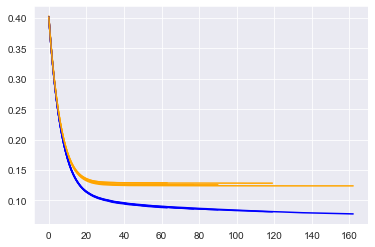


Feature #: 1
[20:40:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:42:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:44:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728

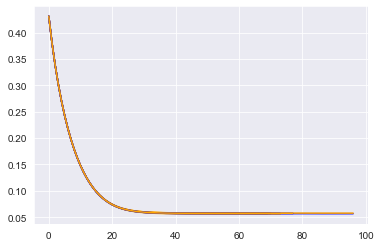


Feature #: 2
[20:48:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:51:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:54:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728

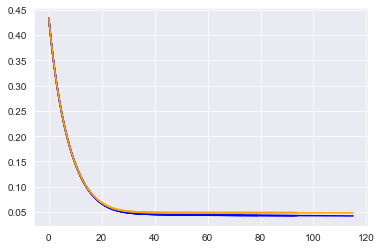


Feature #: 3
[21:04:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:10:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728

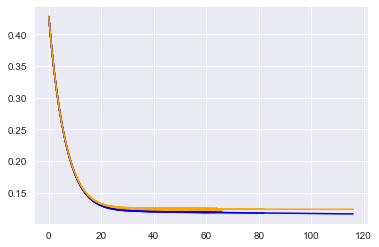


Feature #: 4
[21:16:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:17:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:19:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728

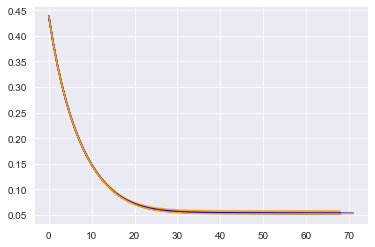


Feature #: 5
[21:22:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:23:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:24:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728

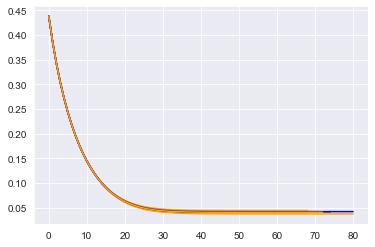


Feature #: 6
[21:29:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:31:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:34:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728

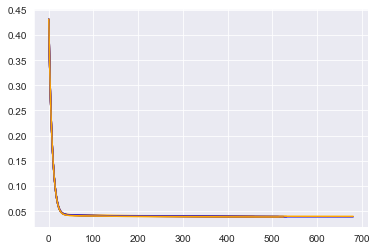


Feature #: 7
[21:42:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:45:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728

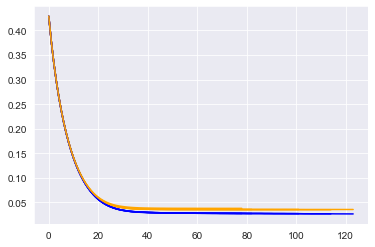

In [125]:
rmses, epochss=[],[]
for i in range(8):
    print('Feature #: '+str(i))
    rmse, epochs = runKfold(inp, out, i, best_cfg)
    rmses.append(rmse)
    epochss.append(epochs)
    print()

# Now train as multioutput

In [13]:
epochss=[92,67,81,68,58,63,100,90]

In [37]:
from sklearn.multioutput import MultiOutputRegressor

x_train, x_test, y_train, y_test = train_test_split(inp, out, test_size=0.20, random_state=32)

models=[]
for num in range(8):
    
    tmpparms = best_cfgs[num]
    tmpparms.pop("file", None)    
    tmpparms['n_estimators']=int(epochss[num])
    tmpparms['objective']= 'reg:squarederror'
    print(tmpparms)
    
    models.append(MultiOutputRegressor(
        XGBRegressor(**tmpparms)))
    models[-1].fit(x_train, y_train[:,num::8])

{'loss': 0.13307, 'min_child_weight': 1.0, 'subsample': 0.7, 'eta': 0.3, 'colsample_bytree': 0.6, 'alpha': 0.0, 'lambda': 1.0, 'gamma': 0.1, 'max_depth': 12, 'n_estimators': 92, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'learning_rate': 0.1}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[14:46:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:53:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:58:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/sr

//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[19:31:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:32:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:34:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/sr

//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[21:44:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:48:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/sr

//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[23:48:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:49:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:51:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/sr

//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[01:06:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:07:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:07:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/sr

//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[01:34:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:35:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:36:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/sr

//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[02:12:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:12:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:12:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/sr

//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[02:25:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:26:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:27:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/sr

In [38]:
def multiprediction(inpt, models):
    
    preds=[]
    for model in models:
        preds.append(model.predict(inpt))

    preds = np.array(preds)   
    preds = np.resize(preds, (preds.shape[1], preds.shape[2]*preds.shape[0]))
    
    rearranged=[]
    for i in range(8):
        for j in range(48):
            rearranged.append(i+8*j)
        
    return preds[:,rearranged]

In [39]:
y_pred = multiprediction(x_test, models)

In [40]:
from sklearn.metrics import mean_squared_error as mse
mse(y_pred,y_test)

0.09660347408810599

In [19]:
from sklearn.metrics import mean_squared_error as mse
mse(y_pred,y_test)

0.0967234595244972

# Manual inspection

In [41]:
pred=multiprediction(x_test, models)

In [21]:
print('Baseline WSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))

print(np.abs(out[1]-out[10]).sum())
print(np.abs(out[50]-out[60]).sum())
print(np.abs(out[100]-out[110]).sum())

Baseline WSE: 0.078
Baseline WSE l1: 0.104
Baseline MSE: 0.052
Baseline MSE l1: 0.069
36.36507936507937
24.09365079365079
34.76825396825397


In [42]:
print('Baseline WSE: {:.3f}'.format(WSE2(pred[0],out[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(pred[0],out[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(pred[0],out[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(pred[0],out[0], a=1, b=1)))

print(np.abs(pred[1]-pred[10]).sum())
print(np.abs(pred[50]-pred[60]).sum())
print(np.abs(pred[100]-pred[110]).sum())

Baseline WSE: 0.221
Baseline WSE l1: 0.272
Baseline MSE: 0.384
Baseline MSE l1: 0.466
159.0847
167.2865
170.23868


In [43]:
def revert_output(output,multiplier=denominator,lineup=None):

    reframe=pd.DataFrame(output.reshape(48,8),
                 columns=['minutes','goals','assists','cards_yellow','cards_red','own_goals','goals_against','saves'])
    
    reframe[reframe<0] = 0
    if lineup is not None:
        reframe.index=lineup
        reframe.drop([x for x in reframe.index if x.startswith('dummy')], axis=0, inplace=True)
    
    
    #reframe['minutes']*=90
    reframe=reframe*denominator[:8]
    byteamframe=pd.concat([reframe.iloc[:24,:].sum(axis=0),reframe.iloc[24:,:].sum(axis=0)], axis=1).T
    
    return reframe, byteamframe[byteamframe.columns[1:]]

In [44]:
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[0])
print(byteamframe)
reframe, byteamframe = revert_output(out[0])
print(byteamframe)

       goals    assists  cards_yellow  cards_red  own_goals  goals_against  \
0  42.231604  52.226532     20.354771  12.584358  12.135733      94.516784   
1  43.887193  43.217779     17.954146  10.689709  10.379910      88.191631   

        saves  
0  198.768923  
1  148.252842  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0    4.0      4.0           1.0        0.0        0.0            0.0    4.0
1    0.0      0.0           2.0        0.0        0.0            4.0    4.0
